In [1]:
import math, codecs, os.path, numpy as np

def isZero(x):
    return -1e-9 < x < 1e-9

def calc_rain_days_distr_density( prob_rain, nb_generations):
  if isZero(prob_rain):
    density = [int(i == nb_generations) for i in range(nb_generations + 1)]
  elif isZero(1-prob_rain):
    density = [int(i == 0) for i in range(nb_generations + 1)]
  else:
    density = [None] * (nb_generations + 1)
    density[0] = prob_rain ** nb_generations
    for i in range(1, nb_generations+1):
      density[i] = density[i-1] * ((nb_generations - i + 1.) / i) * ((1. - prob_rain) / prob_rain)
  assert 0<=min(density) < max(density) <=1, f'({[prob_rain, density[-5:]]})'
  return density

def calc_nb_tribble_given_number_sunny_days_density(prob_choose_mountains, nb_generations):
  if isZero(prob_choose_mountains):
    nb_tribble_given_number_sunny_days_density = [int(i == nb_generations) for i in range(nb_generations + 1)]
  elif isZero(1-prob_choose_mountains):
    nb_tribble_given_number_sunny_days_density = [int(i == 0) for i in range(nb_generations + 1)]
  else:
    nb_tribble_given_number_sunny_days_density = [(prob_choose_mountains) ** (nb_generations - i) * (1. - prob_choose_mountains) ** i
                                                                                                      for i in range(nb_generations+1)] 
  return nb_tribble_given_number_sunny_days_density

def get_ES_indices_thresholds(rain_days_distr_density, thresholds_ES):
  result = []
  cumul_prob_number_sunny_days_reversed = np.cumsum([0] + rain_days_distr_density[::-1])
  for threshold_ES in thresholds_ES:
    ind = np.searchsorted(cumul_prob_number_sunny_days_reversed, threshold_ES, 'right')
    assert cumul_prob_number_sunny_days_reversed[ind-1] <= threshold_ES <= cumul_prob_number_sunny_days_reversed[ind],\
      f'{[ind, cumul_prob_number_sunny_days_reversed[ind-1], threshold_ES, cumul_prob_number_sunny_days_reversed[ind]]}'
      
    scaling_factor = (threshold_ES - cumul_prob_number_sunny_days_reversed[ind-1]) \
                        / (cumul_prob_number_sunny_days_reversed[ind] - cumul_prob_number_sunny_days_reversed[ind-1])
    
    assert 0 <= scaling_factor <= 1, f'{[ind, scaling_factor, cumul_prob_number_sunny_days_reversed[ind-1], threshold_ES, cumul_prob_number_sunny_days_reversed[ind]]}'
    resid = cumul_prob_number_sunny_days_reversed[ind]  * scaling_factor \
            + cumul_prob_number_sunny_days_reversed[ind-1] * (1 - scaling_factor) - threshold_ES
    assert -1e-10 <= resid <= 1e-10,\
      f'{[resid, scaling_factor, cumul_prob_number_sunny_days_reversed[ind-1], 1-threshold_ES, cumul_prob_number_sunny_days_reversed[ind]]}'
    result.append([threshold_ES, len(rain_days_distr_density) - ind, scaling_factor])
  return result

def get_tribbles_survival_probability_growth_CF(indices_thresholds, expected_nb_tribbles,
                                                rain_days_distr_density, nb_tribble_given_number_sunny_days):
    cumul_expected_shortfall_before_norm = np.cumsum(np.insert(
                                              np.multiply(rain_days_distr_density, nb_tribble_given_number_sunny_days), 0, 0))           
    assert isZero(cumul_expected_shortfall_before_norm[-1] - expected_nb_tribbles), cumul_expected_shortfall_before_norm[-1] - expected_nb_tribbles
    ES_values = []
    for threshold_ES, ind, scaling_factor in indices_thresholds:
        weighted_cumul_expected_shortfall_before_norm = ( cumul_expected_shortfall_before_norm[ind] * scaling_factor
                                                         + cumul_expected_shortfall_before_norm[ind + 1] * (1 - scaling_factor))
        ES_values.append(weighted_cumul_expected_shortfall_before_norm / (1 - threshold_ES))

    return ES_values

def calc_expected_nb_tribbles_expected_std_dev_relative(nb_generations, prob_rain, prob_choose_mountains):
  expected_nb_tribbles = ((prob_rain * prob_choose_mountains + (1 - prob_rain) * (1 - prob_choose_mountains))) ** nb_generations
  expected_variance = \
      ((prob_rain * (prob_choose_mountains ** 2) + (1 - prob_rain) * ((1 - prob_choose_mountains) ** 2)) ** nb_generations \
        - ((prob_rain * prob_choose_mountains + (1 - prob_rain) * (1 - prob_choose_mountains))) ** (2 * nb_generations))
  expected_std_dev_relative = math.sqrt(expected_variance) / expected_nb_tribbles  
  return [expected_nb_tribbles, expected_std_dev_relative]
                
def write_to_file(file_path, file_content, my_encoding='utf-8'):
    with codecs.open(file_path, 'w', encoding=my_encoding) as the_file:
        the_file.writelines([(','.join([str(x) for x in an_array]) + '\n') for an_array in file_content])

In [2]:
nb_generations=100
thresholds_ES=[0., 0.001, 0.01, 0.05, 0.1, 0.5]
import pandas as pd
pd.set_option('display.max_rows', None)

all_rain_percentages = [0.1, 0.5, 1, 3, 5, 10, 20, 30, 40]
all_mountain_percentages = [0, 0.1, 0.5, 1, 2, 8, 49]
for rp in all_rain_percentages:
  if rp >= 3:
    all_mountain_percentages += ([rp, rp + 1])
all_mountain_percentages.sort()
nbs_tribble_given_number_sunny_days = {prob_choose_mountains : 
  calc_nb_tribble_given_number_sunny_days_density(prob_choose_mountains/100., nb_generations) for prob_choose_mountains in all_mountain_percentages}

data = {pr : {} for pr in all_rain_percentages}
densities = {pr : [] for pr in all_rain_percentages}

all_mountain_percentages_without_zero = all_mountain_percentages[1:]
expected_growth_rate = {percentage_rains : [percentage_rains/100. * math.log(percentage_choose_mountains/100.) 
                             + (1-percentage_rains/100.) * math.log(1-percentage_choose_mountains/100.)
                                  for percentage_choose_mountains in all_mountain_percentages_without_zero] 
                                       for percentage_rains in all_rain_percentages}

for percentage_rains in all_rain_percentages:
    rain_days_distr_density = calc_rain_days_distr_density( prob_rain=percentage_rains/100.0, nb_generations=nb_generations)
    densities[percentage_rains] = rain_days_distr_density
    indices_thresholds = get_ES_indices_thresholds(rain_days_distr_density, thresholds_ES)
    for percentage_choose_mountains, nb_tribble_given_number_sunny_days in nbs_tribble_given_number_sunny_days.items():
        prob_rain, prob_choose_mountains = percentage_rains / 100.0, percentage_choose_mountains / 100.0
        expected_nb_tribbles = ((prob_rain * prob_choose_mountains + (1 - prob_rain) * (1 - prob_choose_mountains))) ** nb_generations
        result_ESs = get_tribbles_survival_probability_growth_CF(
                                        indices_thresholds=indices_thresholds,
                                        expected_nb_tribbles=expected_nb_tribbles, 
                                        rain_days_distr_density=rain_days_distr_density,
                                        nb_tribble_given_number_sunny_days=nb_tribble_given_number_sunny_days)
        
        data[percentage_rains][percentage_choose_mountains] = calc_expected_nb_tribbles_expected_std_dev_relative(
                                                                    nb_generations, prob_rain, prob_choose_mountains) + result_ESs

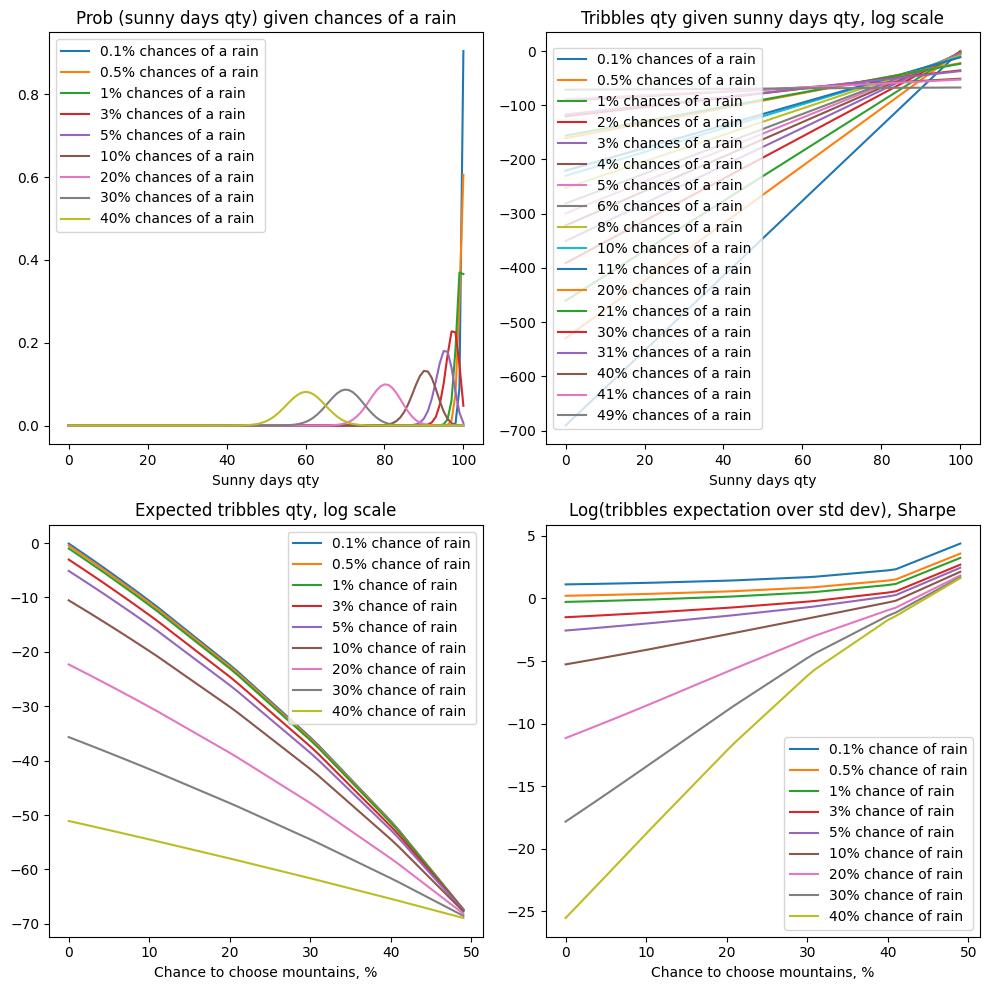

In [3]:
import matplotlib.pyplot as plt

fig, all_axes = plt.subplots(2, 2, figsize=[10, 10], dpi=100)
#fig.suptitle('Densities')
ax0, ax1, ax3, ax31 = all_axes[0][0], all_axes[0][1], all_axes[1][0], all_axes[1][1]
for percentage_rains in (all_rain_percentages):
  ax0.plot(densities[percentage_rains], label=f'{(percentage_rains)}% chances of a rain')
ax0.set_title('Prob (sunny days qty) given chances of a rain')
ax0.legend()
ax1.set_title('Tribbles qty given sunny days qty, log scale')
for perc, data2 in nbs_tribble_given_number_sunny_days.items():
  if perc != 0:
    ax1.plot([math.log(p) for p in data2], label=f'{perc}% chances of a rain')
ax1.legend(loc='center left')
for ax_ in [ax0, ax1]:
  ax_.set_xlabel('Sunny days qty')
ax3.set_title('Expected tribbles qty, log scale')
for percentage_rains in all_rain_percentages:
  ax3.plot(all_mountain_percentages, [math.log(data[percentage_rains][pm][0]) for pm in all_mountain_percentages], label=f'{percentage_rains}% chance of rain')
ax3.set_xlabel('Chance to choose mountains, %')
ax3.legend()

ax31.set_title('Log(tribbles expectation over std dev), Sharpe')
for percentage_rains in all_rain_percentages:
  ax31.plot(all_mountain_percentages, [-math.log(data[percentage_rains][pm][1]) for pm in all_mountain_percentages], 
               label=f'{percentage_rains}% chance of rain')
ax31.set_xlabel('Chance to choose mountains, %')
ax31.legend()
fig.tight_layout()


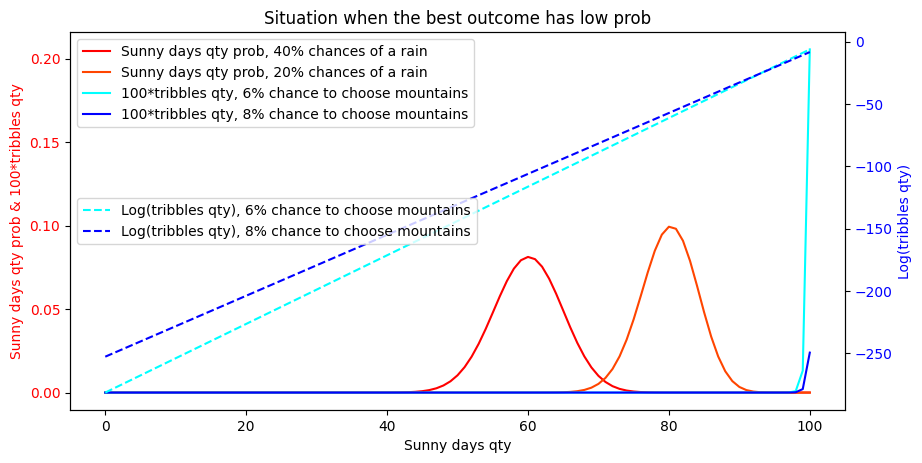

In [4]:
fig, all_axes = plt.subplots(1, 1, figsize=[10, 5], dpi=100)
#fig.suptitle('Densities')
ax2_ = all_axes
ax2_.plot(densities[40], label=f'Sunny days qty prob, 40% chances of a rain', color='red')
ax2_.plot(densities[20], label=f'Sunny days qty prob, 20% chances of a rain', color='orangered')
ax2_.plot([100*t for t in nbs_tribble_given_number_sunny_days[6]], label=f'100*tribbles qty, 6% chance to choose mountains', color='aqua')
ax2_.plot([100*t for t in nbs_tribble_given_number_sunny_days[8]], label=f'100*tribbles qty, 8% chance to choose mountains', color='blue')
ax2_.tick_params(axis='y', labelcolor='red')
ax2_.set_ylabel('Sunny days qty prob & 100*tribbles qty', color='red')
ax2_.legend()
ax2_.set_title('Situation when the best outcome has low prob')
ax2 = ax2_.twinx()
#ax2.plot(nbs_tribble_given_number_sunny_days[4], label=f'Tribbles qty, 4% chance to choose mountains', color='dodgerblue')
ax2.plot([math.log(t) for t in nbs_tribble_given_number_sunny_days[6]], label=f'Log(tribbles qty), 6% chance to choose mountains', color='aqua', linestyle='dashed')
ax2.plot([math.log(t) for t in nbs_tribble_given_number_sunny_days[8]], label=f'Log(tribbles qty), 8% chance to choose mountains', color='blue', linestyle='dashed')
ax2.legend(loc='center left')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('Log(tribbles qty)', color='blue')
ax2_.set_xlabel('Sunny days qty');

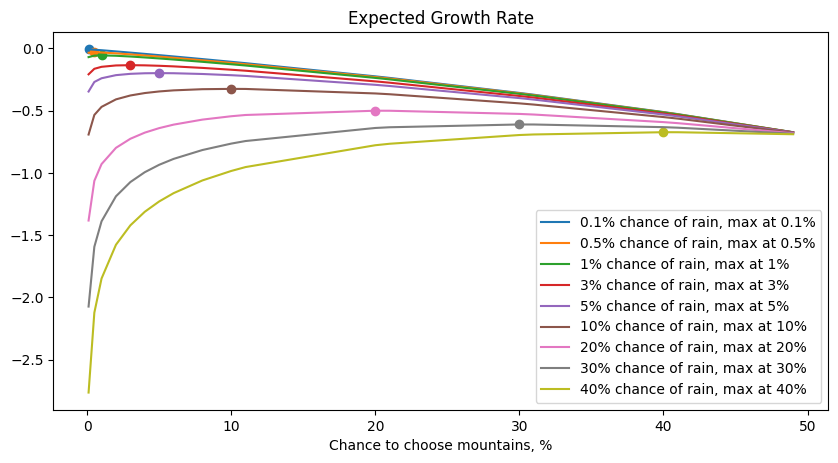

In [5]:
fig, _axes = plt.subplots(1, 1, figsize=[10, 5], dpi=100)
_axes.set_title('Expected Growth Rate')
for percentage_rains, expected_growth_rate_given_rain_prob in expected_growth_rate.items():
  amax = np.argmax(expected_growth_rate_given_rain_prob)
  _axes.plot(all_mountain_percentages_without_zero, expected_growth_rate_given_rain_prob, 
              label=f'{percentage_rains}% chance of rain, max at {all_mountain_percentages_without_zero[amax]}%')
  _axes.scatter([all_mountain_percentages_without_zero[amax]], [expected_growth_rate_given_rain_prob[amax]])
_axes.legend()
_axes.set_xlabel('Chance to choose mountains, %');
  

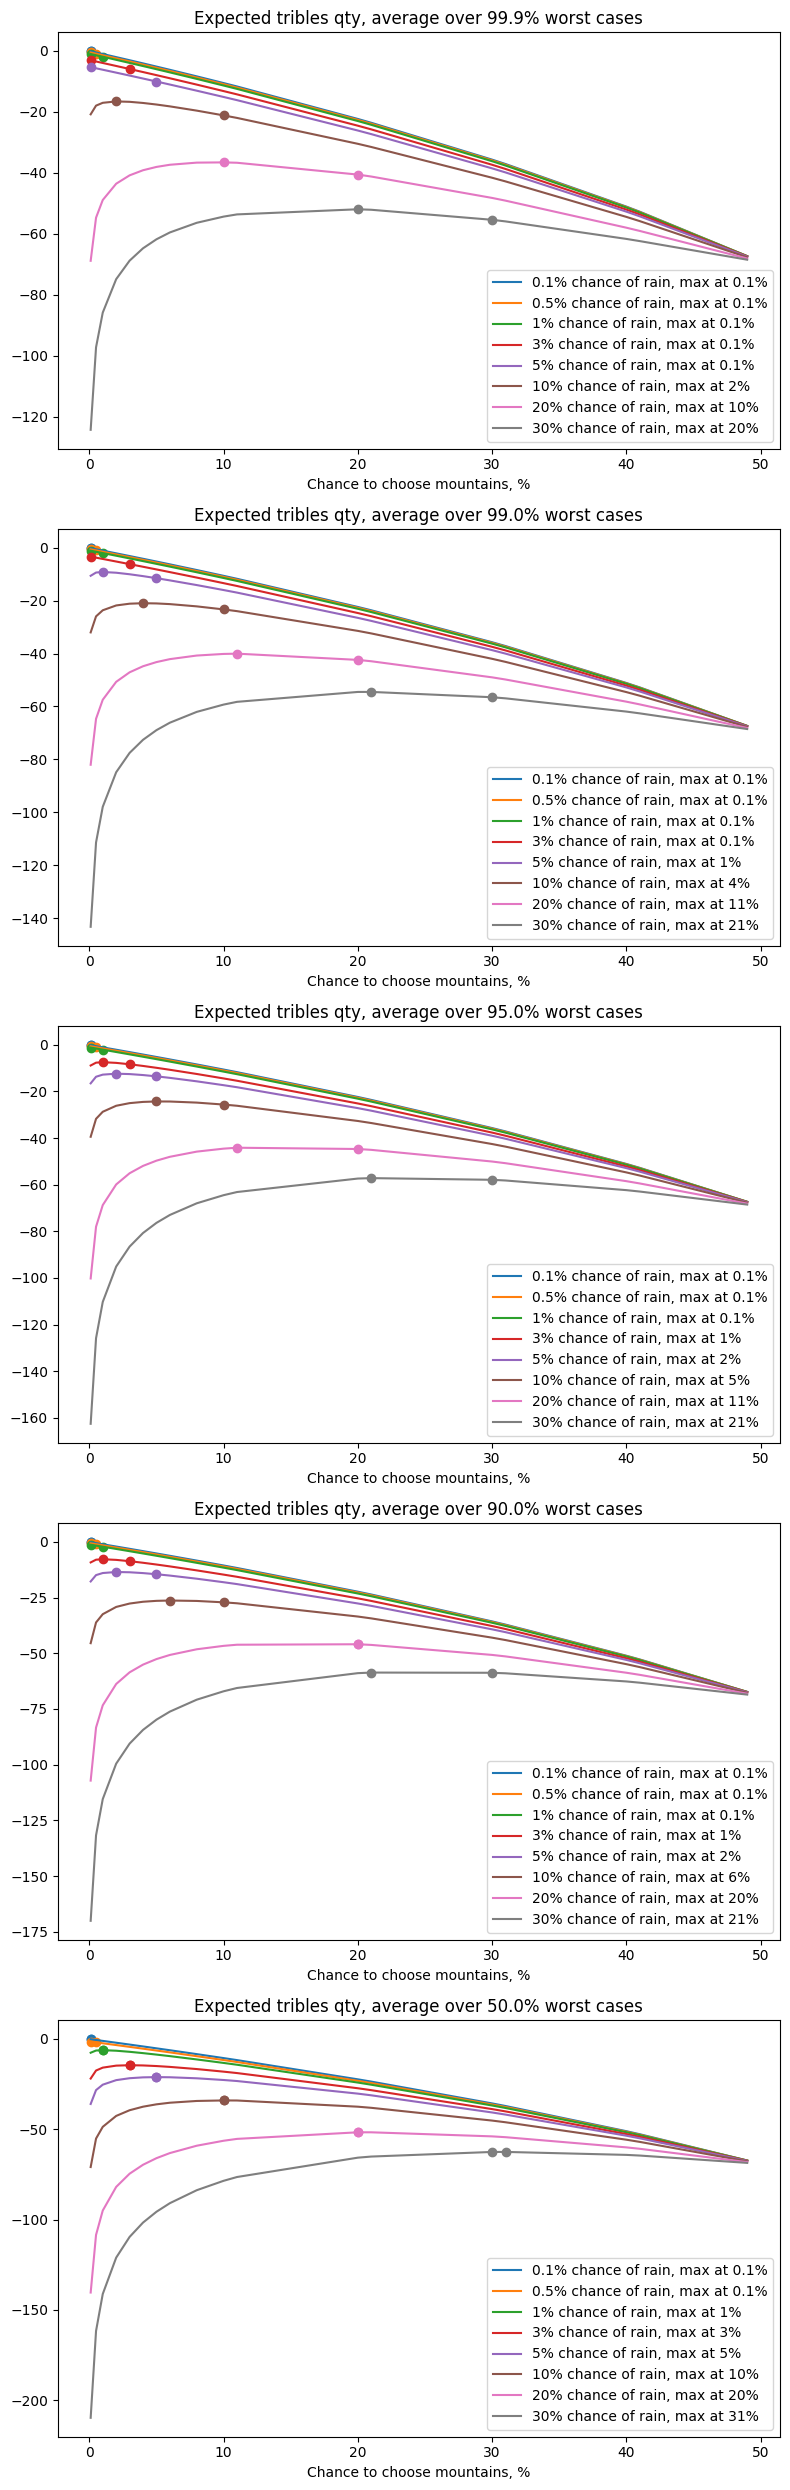

In [6]:
thresholds_ES_2 = [t for t in thresholds_ES if t > 0.]
fig, all_axes = plt.subplots(len(thresholds_ES_2), 1, figsize=[8, 5*len(thresholds_ES_2)], dpi=100)
for i, (ax_, t) in enumerate(zip(all_axes, thresholds_ES_2)):
  ax_.set_title(f'Expected tribles qty, average over {(1-t)*100}% worst cases')
  ax_.set_xlabel('Chance to choose mountains, %')
  for percentage_rains in all_rain_percentages:
    if percentage_rains > 30:
      continue
    data_array_log = [math.log(data[percentage_rains][pm][-len(thresholds_ES_2)+i]) for pm in all_mountain_percentages_without_zero]
    amax = np.argmax(data_array_log)
    expected_max = all_mountain_percentages_without_zero.index(percentage_rains)
    ax_.scatter([all_mountain_percentages_without_zero[k] for k in [amax, expected_max]], [data_array_log[k] for k in [amax, expected_max]])
    ax_.plot(all_mountain_percentages_without_zero, data_array_log, label=f'{percentage_rains}% chance of rain, max at {all_mountain_percentages_without_zero[amax]}%')
  ax_.legend()
fig.tight_layout()

In [7]:
columns=['prob rain', 'prob mountains', 
                'expected nb tribbles', 'expected std dev relative'] + ['normalized ES @ ' + str((1 - tr) * 100) + '%' for tr in thresholds_ES]
data_flat = [[percentage_rains, percentage_choose_mountains] + data[percentage_rains][percentage_choose_mountains]
                 for percentage_rains in all_rain_percentages for percentage_choose_mountains in all_mountain_percentages]
pd.DataFrame(data_flat, columns=columns)

,prob rain,prob mountains,expected nb tribbles,expected std dev relative,normalized ES @ 100.0%,normalized ES @ 99.9%,normalized ES @ 99.0%,normalized ES @ 95.0%,normalized ES @ 90.0%,normalized ES @ 50.0%
0,0.1,0.0,9.047921e-01,3.243859e-01,9.047921e-01,9.046968e-01,9.038305e-01,8.997812e-01,8.942135e-01,8.095843e-01
1,0.1,0.1,8.187309e-01,3.240445e-01,8.187309e-01,8.186447e-01,8.178616e-01,8.142013e-01,8.091685e-01,7.326696e-01
2,0.1,0.5,5.483721e-01,3.226727e-01,5.483721e-01,5.483146e-01,5.477923e-01,5.453511e-01,5.419945e-01,4.909738e-01
3,0.1,1.0,3.315182e-01,3.209435e-01,3.315182e-01,3.314837e-01,3.311696e-01,3.297017e-01,3.276833e-01,2.970041e-01
4,0.1,2.0,1.202385e-01,3.174362e-01,1.202385e-01,1.202261e-01,1.201134e-01,1.195869e-01,1.188628e-01,1.078575e-01
5,0.1,3.0,4.315854e-02,3.138620e-01,4.315854e-02,4.315414e-02,4.311416e-02,4.292728e-02,4.267032e-02,3.876457e-02
6,0.1,4.0,1.532793e-02,3.102190e-01,1.532793e-02,1.532638e-02,1.531235e-02,1.524675e-02,1.515655e-02,1.378554e-02
7,0.1,5.0,5.385144e-03,3.065050e-01,5.385144e-03,5.384608e-03,5.379736e-03,5.356966e-03,5.325657e-03,4.849759e-03
8,0.1,6.0,1.871152e-03,3.027181e-01,1.871152e-03,1.870968e-03,1.869296e-03,1.861482e-03,1.850738e-03,1.687428e-03
9,0.1,8.0,2.183291e-04,2.949159e-01,2.183291e-04,2.183082e-04,2.181182e-04,2.172300e-04,2.160088e-04,1.974463e-04
